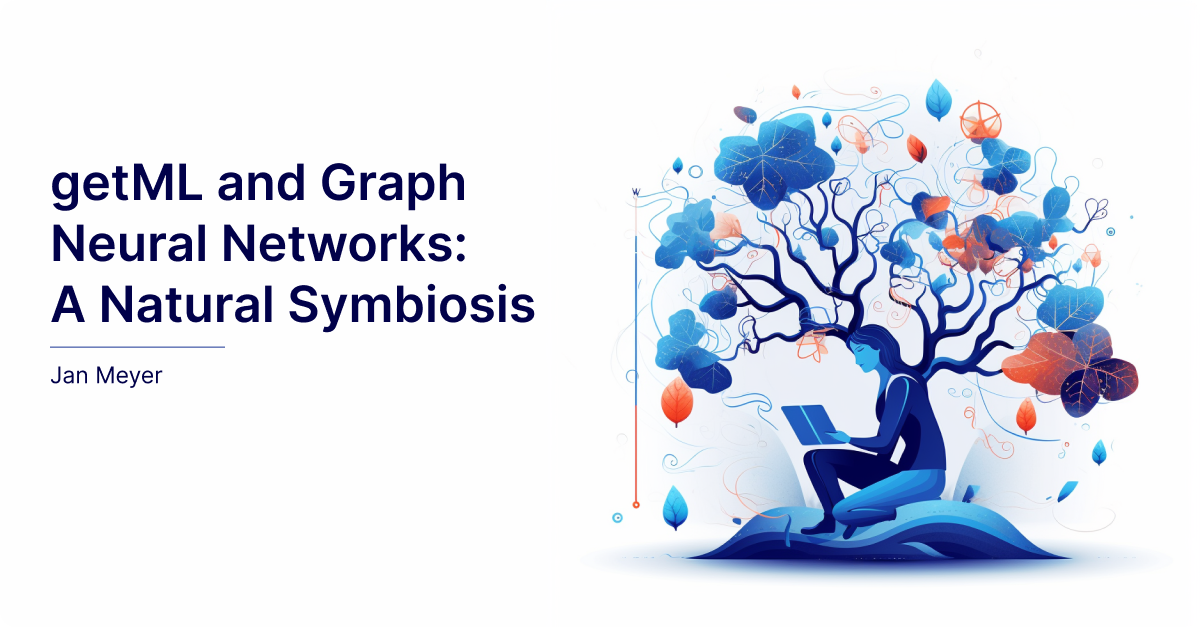

# **getML and Graph Neural Networks: A Natural Symbiosis**

In the [previous notebook](https://www.kaggle.com/code/jankmeyer/cora-relational-learning-vs-graph-neural-networks/notebook) we compared the predictive performance of getML's relational feature learning approach with off-the-shelf Graph Neural Network (GNN) implementations. We demonstrated a slight performance gain when using the relational feature learner over the GNN approach. Naturally, now the question arises: is it possible to combine both approaches, pick the best of both worlds and boost predictive power?

The answer is a resounding Yes!

The input to GNN's Neural Network is the one-hot-encoded word matrix of the papers' abstracts. This matrix is very sparse and represents target relevant information inefficently.
getML's power lies in aggregating over large amounts of data and distilling relevant target information into few, highly optimized features. That means, both approaches are completely compatible!
Features are engineered from word matrix based on the tabular form of the CORA data set. That smaller set of features is given to the GNN to learn the embeddings for every node and predict its class label.

And that is exactly what we will do in this notebook!

# Table of Contents
- [Setup and Download of Data](#setup)
- [Data Preparation](#dataprep)
- [Feature Learning with getML](#featurelearning)
- [Graph Neural Network with getML Engineered Features](#GNN)
- [Comparison of Approaches](#Comparison)
- [Conclusion](#Conclusion)

# Setup and Download of Data <a class="anchor"  id="setup"></a>


With respect to contextual settings, we keep everything as in the former notebook: We use the well entrenched benchmarking data set CORA, which consists of academic papers, their references and the word composition of their respective abstracts. We start out from the tabular format of the data set. Make sure you use Python 3.9.19.

In [1]:
# You might need to restart the kernel after the installs
!pip install getml==1.3.2 >/dev/null 2>/dev/null
!pip install pyarrow==7.0.0 >/dev/null 2>/dev/null
!pip install torch-geometric >/dev/null 2>/dev/null
!wget https://static.getml.com/download/1.3.2/getml-1.3.2-x64-linux.tar.gz
!tar -xzvf getml-1.3.2-x64-linux.tar.gz >/dev/null 2>/dev/null
!getml-1.3.2-x64-linux/getML install >/dev/null 2>/dev/null
!pip install pandas >/dev/null 2>/dev/null
!pip install matplotlib >/dev/null 2>/dev/null
!pip install seaborn >/dev/null 2>/dev/null
!pip install numpy==1.26 >/dev/null 2>/dev/null
!pip install torch >/dev/null 2>/dev/null

--2023-07-12 14:05:54--  https://static.getml.com/download/1.3.2/getml-1.3.2-x64-linux.tar.gz
Resolving static.getml.com (static.getml.com)... 104.26.1.177, 172.67.73.139, 104.26.0.177, ...
Connecting to static.getml.com (static.getml.com)|104.26.1.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54716264 (52M) [application/x-gzip]
Saving to: ‘getml-1.3.2-x64-linux.tar.gz’

getml-1.3.2-x64-lin 100%[===================>]  52.18M   173MB/s    in 0.3s    

2023-07-12 14:05:54 (173 MB/s) - ‘getml-1.3.2-x64-linux.tar.gz’ saved [54716264/54716264]



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

import getml

getml.engine.launch()
getml.engine.set_project("getml_gnn_cora")

getML engine is already running.

Connected to project 'getml_gnn_cora'
http://localhost:1709/#/listprojects/getml_gnn_cora/


In [2]:
conn = getml.database.connect_mysql(
    host="db.relational-data.org",
    dbname="CORA",
    port=3306,
    user="guest",
    password="relational"
)

In [3]:
def load_if_needed(name):
    if not getml.data.exists(name):
        data_frame = getml.data.DataFrame.from_db(name=name, table_name=name, conn=conn)
        data_frame.save()
    else:
        data_frame = getml.data.load_data_frame(name)
    return data_frame

In [4]:
paper = load_if_needed("paper")
cites = load_if_needed("cites")
content = load_if_needed("content")

# Data Preparation <a class="anchor"  id="dataprep"></a>

Data preparation is similar to the "ordinary" GNN analysis. We establish the node index and derive from it the edge index. The main difference is, that we do not need to vectorize the word information, because we replace the raw word information with the feature vector, optimized by getML. However, later we use the original GNN implementation for comparison purposes. For this purpose, we vectorize the word information and add it to the dataframe.

In [5]:
paper_df = paper.to_pandas()
cites_df = cites.to_pandas()
content_df = content.to_pandas()

In [6]:
def vectorize(word_list):
    word_vector = np.zeros(vocab_size, dtype=int)
    word_vector[word_list] = 1
    return word_vector


vocab_size = content_df["word_cited_id"].nunique() + 1

content_df["paper_id"] = content_df["paper_id"].astype(int)
content_df["word_list"] = content_df["word_cited_id"].apply(lambda x: int(x[4:]) - 1)
vector_content_df = content_df.groupby("paper_id").agg(list)
vector_content_df["word_vector"] = vector_content_df["word_list"].apply(
    lambda x: vectorize(x)
)

In [7]:
paper_df["paper_id"] = paper_df["paper_id"].astype(int)
paper_df["class_label_enc"] = paper_df["class_label"].astype("category").cat.codes
num_classes = paper_df["class_label_enc"].nunique()

_df = paper_df[["class_label_enc", "class_label"]].drop_duplicates()
_df.index = _df.class_label_enc
label_mapping = _df.sort_index().to_dict()["class_label"]

In [8]:
index_aligned_df = paper_df.merge(vector_content_df, on="paper_id")
index_aligned_df = index_aligned_df.sample(frac=1, random_state=1).reset_index(
    drop=True
)  # Randomization step
index_aligned_df["node_index"] = index_aligned_df.index

Citations across papers constitute the edges of the Network. Now we align them with the index of the nodes.

In [9]:
cites_df = cites_df.astype({"cited_paper_id": int, "citing_paper_id": int})

cites_df = cites_df.merge(
    index_aligned_df[["paper_id", "node_index"]],
    how="left",
    left_on="cited_paper_id",
    right_on="paper_id",
    copy=False,
)
cites_df.rename(columns={"node_index": "cited_node_index"}, inplace=True)
cites_df.drop("paper_id", axis=1, inplace=True)

cites_df = cites_df.merge(
    index_aligned_df[["paper_id", "node_index"]],
    how="left",
    left_on="citing_paper_id",
    right_on="paper_id",
    copy=False,
)
cites_df.rename(columns={"node_index": "citing_node_index"}, inplace=True)
cites_df.drop("paper_id", axis=1, inplace=True)
cites_df

,cited_paper_id,citing_paper_id,cited_node_index,citing_node_index
0,35,887,1217,1930
1,35,1033,1217,1804
2,35,1688,1217,2112
3,35,1956,1217,2333
4,35,8865,1217,726
...,...,...,...,...
5424,853116,19621,113,1967
5425,853116,853155,113,2577
5426,853118,1140289,2591,683
5427,853155,853118,2577,2591


In [10]:
_cited_node = cites_df["cited_node_index"].values
_citing_node = cites_df["citing_node_index"].values

cited_node = np.concatenate((_citing_node, _cited_node))
citing_node = np.concatenate((_cited_node, _citing_node))

In [11]:
train_share = 0.7
n_papers = len(index_aligned_df)
cut_off = int(n_papers * train_share)
train_mask = n_papers * [False]
train_mask[:cut_off] = cut_off * [True]
test_mask = [not e for e in train_mask]

# Feature Learning with getML <a class="anchor"  id="featurelearning"></a>

Now that we have an index aligned feature matrix, label vector (class_label_enc) and an edge index that builds on the aligned node indices, we can break from the established GNN routine: we enter getML territory.
The procedure is very similar to the getML implementation of the previous notebook. The difference lies in the fact that we won't apply a predictor, but leave it with feature learners.

There is one more important detail to caution for. Even though we "only" learn the features with the getML routine, we have to guard us from subtle data leakage. We must only use data for feature learning, that is used later on in GNN modeling. This is also the main reason, why the getML feature learning doesn't precede data preparation in its entirety: to ensure the train test split is identical for both processing steps.


In [12]:
data_train = getml.DataFrame.from_pandas(
    index_aligned_df[["paper_id", "class_label"]][train_mask], name="data_train"
)
data_test = getml.DataFrame.from_pandas(
    index_aligned_df[["paper_id", "class_label"]][test_mask], name="data_test"
)

paper, split = getml.data.split.concat("population", train=data_train, test=data_test)

getML requires that we define *roles* for each of the columns.

Also, the goal is to predict seven different labels. We generate a target column for each of those labels.

In [13]:
paper.set_role("paper_id", getml.data.roles.join_key)
paper.set_role("class_label", getml.data.roles.categorical)

cites.set_role(["cited_paper_id", "citing_paper_id"], getml.data.roles.join_key)

content.set_role("paper_id", getml.data.roles.join_key)
content.set_role("word_cited_id", getml.data.roles.categorical)

data_full = getml.data.make_target_columns(paper, "class_label")

In [14]:
container = getml.data.Container(population=data_full, split=split)
container.add(cites=cites, content=content, paper=paper)
container.freeze()

To get started with relational learning, we need to specify the data model. Even though the data set itself is quite simple with only three tables and six columns in total, the resulting data model is actually quite complicated.

That is because the class label can be predicted using three different pieces of information:

- The keywords used by the paper
- The keywords used by papers it cites and by papers that cite the paper
- The class label of papers it cites and by papers that cite the paper

The main challenge here is that `cites` is used twice, once to connect the _cited_ papers and then to connect the _citing_ papers. To resolve this, we need two placeholders on `cites`.

In [15]:

dm = getml.data.DataModel(paper.to_placeholder("population"))

# We need two different placeholders for cites.
dm.add(getml.data.to_placeholder(cites=[cites] * 2, content=content, paper=paper))

dm.population.join(dm.cites[0], on=("paper_id", "cited_paper_id"))

dm.cites[0].join(dm.content, on=("citing_paper_id", "paper_id"))

dm.cites[0].join(
    dm.paper,
    on=("citing_paper_id", "paper_id"),
    relationship=getml.data.relationship.many_to_one,
)

dm.population.join(dm.cites[1], on=("paper_id", "citing_paper_id"))

dm.cites[1].join(dm.content, on=("cited_paper_id", "paper_id"))

dm.cites[1].join(
    dm.paper,
    on=("cited_paper_id", "paper_id"),
    relationship=getml.data.relationship.many_to_one,
)

dm.population.join(dm.content, on="paper_id")

dm

,data frames,staging table
0,population,POPULATION__STAGING_TABLE_1
1,"cites, paper",CITES__STAGING_TABLE_2
2,"cites, paper",CITES__STAGING_TABLE_3
3,content,CONTENT__STAGING_TABLE_4


We use the FastProp algorithm for feature learning. Again, no predictor is required, and the pipeline is built without one.

In [16]:
mapping = getml.preprocessors.Mapping()

fast_prop = getml.feature_learning.FastProp(
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    num_threads=1,
)

In [17]:
pipe1 = getml.pipeline.Pipeline(
    tags=["fast_prop"],
    data_model=dm,
    preprocessors=[mapping],
    feature_learners=[fast_prop],
)

pipe1

Pipeline(data_model='population',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['cites', 'content', 'paper'],
         predictors=[],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['fast_prop'])

Model training

In [18]:
pipe1.fit(container.train)

Checking data model...
Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Checking... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          

INFO [MIGHT TAKE LONG]: The number of unique entries in column 'word_cited_id' in CONTENT__STAGING_TABLE_4 is 1432. This might take a long time to fit. You should consider setting its role to unused_string or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').
INFO [FOREIGN KEYS NOT FOUND]: When joining POPULATION__STAGING_TABLE_1 and CITES__STAGING_TABLE_2 over 'paper_id' and 'cited_paper_id', there are no corresponding entries for 41.719409% of entries in 'paper_id' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys.
INFO [FOREIGN KEYS NOT FOUND]: When joining POPULATION__STAGING_TABLE_1 and CITES__STAGING_TABLE_3 over 'paper_id' and 'citing_paper_id', the

Pipeline(data_model='population',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['cites', 'content', 'paper'],
         predictors=[],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['fast_prop', 'container-zz5PVw'])

url: http://localhost:1709/#/getpipeline/getml_gnn_cora/HZIzwl/0/

Now comes the crucial trick!
Instead of applying the pipeline on our test data to make predictions, we apply the pipeline on our train and test data and transform them to the learned (or optimal) features.
It is these optimized features that will replace the word vectors as node attributes in the graph neural network.

In [19]:
trans_feat_train = pipe1.transform(container.train)
trans_feat_test = pipe1.transform(container.test)

optimized_features = np.concatenate((trans_feat_train, trans_feat_test))

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building features... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building features... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          



# Graph Neural Network with getML Engineered Features <a class="anchor"  id="GNN"></a>

From here on out it is smooth sailing, because everything happens exactly as in the previous notebook. We create the graph object and populate it with the nodes containing the optimized features, the edges and masks.

In [20]:
optimized_x = torch.tensor(optimized_features, dtype=torch.float32)

y = torch.tensor(
    np.array(index_aligned_df["class_label_enc"].values), dtype=torch.long
)
edge_index = torch.tensor([cited_node, citing_node], dtype=torch.int64)

optimized_graph_object = Data(x=optimized_x, edge_index=edge_index, y=y)
optimized_graph_object.train_mask = torch.tensor(train_mask)
optimized_graph_object.test_mask = torch.tensor(test_mask)

/tmp/ipykernel_3831362/2945417185.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  edge_index = torch.tensor([cited_node, citing_node], dtype=torch.int64)


In [21]:
print(optimized_graph_object)
print("==============================================================")

print(f"Number of nodes: {optimized_graph_object.num_nodes}")
print(f"Number of edges: {int(optimized_graph_object.num_edges/2)}")
print(f"Average node degree: {(optimized_graph_object.num_edges) / optimized_graph_object.num_nodes:.2f}")
print(f"Number of training nodes: {optimized_graph_object.train_mask.sum()}")
print(f"Number of test nodes: {optimized_graph_object.test_mask.sum()}")
print(f"Training node label rate: {int(optimized_graph_object.train_mask.sum()) / optimized_graph_object.num_nodes:.2f}")
print(f"Test node label rate: {int(optimized_graph_object.test_mask.sum()) / optimized_graph_object.num_nodes:.2f}")
print(f"Contains isolated nodes: {optimized_graph_object.has_isolated_nodes()}")
print(f"Contains self-loops: {optimized_graph_object.has_self_loops()}")
print(f"Is undirected: {optimized_graph_object.is_undirected()}")

Data(x=[2708, 200], edge_index=[2, 10858], y=[2708], train_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 5429
Average node degree: 4.01
Number of training nodes: 1895
Number of test nodes: 813
Training node label rate: 0.70
Test node label rate: 0.30
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [22]:
class GNNTrain:
    def __init__(self, graph_object, nn_model):
        self.graph_object = graph_object
        self.nn_model = nn_model
        self.loss_function = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(
            nn_model.parameters(), lr=0.01, weight_decay=5e-4
        )

    def train(self):
        self.nn_model.train()
        self.optimizer.zero_grad()
        out = self.nn_model(self.graph_object.x, self.graph_object.edge_index)
        loss = self.loss_function(
            out[self.graph_object.train_mask],
            self.graph_object.y[self.graph_object.train_mask],
        )
        loss.backward()  # compute loss
        self.optimizer.step()  # apply grad
        return loss

    def test(self, mask):
        self.nn_model.eval()
        out = self.nn_model(self.graph_object.x, self.graph_object.edge_index)
        pred = out.argmax(dim=1)
        correct = pred[mask] == self.graph_object.y[mask]
        acc = int(correct.sum()) / int(mask.sum())
        return acc

    def run(self):
        max_test_acc = 0
        test_acc_list = []
        best_model = None
        for epoch in range(1, 1001):
            self.train()
            train_acc = self.test(self.graph_object.train_mask)
            test_acc = self.test(self.graph_object.test_mask)
            test_acc_list.append(test_acc)
            if test_acc > max_test_acc:
                max_test_acc = test_acc
                best_model = self.nn_model
            if epoch % 50 == 0:
                print(
                    f"Epoch: {epoch:03d}, Train acc: {train_acc:.4f}"
                    f", Test acc: {test_acc:.4f}"
                )
        self.test_acc_list = test_acc_list
        self.max_test_acc = max_test_acc
        self.best_model = best_model

In [24]:
nn_model = GCNConv(
    in_channels=optimized_graph_object.num_features,
    out_channels=len(optimized_graph_object.y.unique()),
)
optimized_gcn = GNNTrain(graph_object=optimized_graph_object, nn_model=nn_model)
optimized_gcn.run()
print("Maximum Test Accuracy: ", optimized_gcn.max_test_acc)

Epoch: 050, Train acc: 0.9214, Test acc: 0.9114
Epoch: 100, Train acc: 0.9256, Test acc: 0.9188
Epoch: 150, Train acc: 0.9288, Test acc: 0.9176
Epoch: 200, Train acc: 0.9309, Test acc: 0.9176
Epoch: 250, Train acc: 0.9340, Test acc: 0.9176
Epoch: 300, Train acc: 0.9361, Test acc: 0.9176
Epoch: 350, Train acc: 0.9361, Test acc: 0.9188
Epoch: 400, Train acc: 0.9367, Test acc: 0.9176
Epoch: 450, Train acc: 0.9367, Test acc: 0.9176
Epoch: 500, Train acc: 0.9393, Test acc: 0.9176
Epoch: 550, Train acc: 0.9393, Test acc: 0.9164
Epoch: 600, Train acc: 0.9398, Test acc: 0.9164
Epoch: 650, Train acc: 0.9404, Test acc: 0.9164
Epoch: 700, Train acc: 0.9404, Test acc: 0.9164
Epoch: 750, Train acc: 0.9404, Test acc: 0.9164
Epoch: 800, Train acc: 0.9404, Test acc: 0.9164
Epoch: 850, Train acc: 0.9404, Test acc: 0.9176
Epoch: 900, Train acc: 0.9404, Test acc: 0.9176
Epoch: 950, Train acc: 0.9409, Test acc: 0.9176
Epoch: 1000, Train acc: 0.9409, Test acc: 0.9188
Maximum Test Accuracy:  0.9200492004920

92% Accuracy!
This outcome looks really promising. It compares favourably to the GNN standalone solution (87.6%) and the getML standalone solution (88.3%) of the previous notebook.

# Comparison of Approaches <a class="anchor"  id="Comparison"></a>

Let's dig a bit deeper and lift our results on more solid grounds.
We ran a large scale experiment with 100 random train test splits, the raw results of which can be found below:

In [25]:
getml_accs = [0.89012, 0.87812, 0.87627, 0.89474, 0.87442, 0.8892, 0.89751, 0.88273, 0.88181, 0.88089, 0.88366, 0.87996, 0.89566, 0.87627, 0.89104, 0.87719, 0.88366, 0.88366, 0.87258, 0.8892, 0.89104, 0.8855, 0.87812, 0.8892, 0.88827, 0.88273, 0.87165, 0.86981, 0.88273, 0.88735, 0.8735, 0.87627, 0.87719, 0.8892, 0.88366, 0.87627, 0.88181, 0.86981, 0.87627, 0.89751, 0.8855, 0.87165, 0.87073, 0.88827, 0.88827, 0.88181, 0.88827, 0.88089, 0.87073, 0.8892, 0.89012, 0.87442, 0.88735, 0.87073, 0.89197, 0.89751, 0.88827, 0.89289, 0.88089, 0.8855, 0.88366, 0.88458, 0.88181, 0.87442, 0.88735, 0.86981, 0.87812, 0.86888, 0.86981, 0.88827, 0.87627, 0.88827, 0.89289, 0.88181, 0.87442, 0.88181, 0.8855, 0.88181, 0.87535, 0.87812, 0.86519, 0.89104, 0.8892, 0.88366, 0.87258, 0.87719, 0.87719, 0.88366, 0.87535, 0.87904, 0.88089, 0.88643, 0.88273, 0.89197, 0.89381, 0.89381, 0.87258, 0.89197, 0.86981, 0.8855]

original_accs = [0.88284, 0.87823, 0.86162, 0.87085, 0.87638, 0.87915, 0.88192, 0.86624, 0.88838, 0.86531, 0.88376, 0.87269, 0.88284, 0.87269, 0.87177, 0.86439, 0.8607, 0.87454, 0.8607, 0.87454, 0.87269, 0.88469, 0.85701, 0.89207, 0.88838, 0.87731, 0.86993, 0.87269, 0.87085, 0.87454, 0.86439, 0.89207, 0.87823, 0.87546, 0.87454, 0.86993, 0.87362, 0.869, 0.86347, 0.86347, 0.87454, 0.86531, 0.86624, 0.87454, 0.87454, 0.87269, 0.87546, 0.869, 0.86993, 0.88469, 0.87915, 0.86808, 0.87085, 0.86716, 0.87362, 0.87454, 0.88469, 0.88745, 0.86255, 0.87546, 0.87546, 0.88284, 0.85793, 0.86808, 0.87731, 0.87454, 0.88376, 0.85978, 0.86347, 0.881, 0.86624, 0.88561, 0.88653, 0.89391, 0.87362, 0.869, 0.86993, 0.88376, 0.88376, 0.87362, 0.8524, 0.89483, 0.86808, 0.88284, 0.88192, 0.87546, 0.85886, 0.87269, 0.87269, 0.87915, 0.86255, 0.869, 0.87085, 0.87731, 0.87915, 0.87362, 0.869, 0.881, 0.84963, 0.88376]

optimized_accs = [0.92343, 0.92251, 0.9179, 0.93266, 0.9262, 0.93266, 0.94096, 0.92712, 0.93173, 0.91882, 0.93358, 0.92804, 0.92435, 0.92989, 0.9262, 0.92989, 0.92528, 0.92159, 0.9179, 0.92343, 0.92989, 0.93266, 0.9179, 0.93081, 0.92343, 0.92066, 0.91513, 0.91052, 0.91882, 0.92712, 0.92066, 0.92343, 0.93173, 0.92804, 0.91974, 0.91882, 0.92989, 0.9262, 0.91882, 0.92989, 0.92712, 0.92343, 0.92712, 0.92804, 0.92159, 0.92251, 0.93173, 0.92159, 0.90959, 0.92251, 0.92343, 0.91974, 0.92528, 0.92066, 0.92712, 0.93358, 0.93173, 0.9345, 0.92804, 0.92343, 0.92989, 0.9345, 0.92159, 0.92804, 0.93173, 0.91236, 0.91882, 0.9179, 0.91605, 0.92712, 0.9262, 0.93266, 0.93266, 0.92712, 0.92251, 0.92804, 0.92712, 0.92528, 0.92251, 0.9262, 0.90867, 0.93173, 0.93266, 0.9262, 0.92251, 0.9262, 0.91513, 0.91974, 0.92343, 0.90959, 0.92528, 0.92712, 0.92989, 0.9345, 0.93081, 0.9345, 0.92251, 0.92159, 0.91605, 0.9262]

In [26]:
print("getML standalone mean accuracy: ", round(np.mean(getml_accs), 4))
print("GNN standalone mean accuracy: ", round(np.mean(original_accs), 4))
print("GNN + getML accuracy: ", round(np.mean(optimized_accs), 4))
print()
print("Accuracy gain :", round(np.mean(optimized_accs) - np.mean(original_accs), 4))

getML standalone mean accuracy:  0.8823
GNN standalone mean accuracy:  0.8739
GNN + getML accuracy:  0.925

Accuracy gain : 0.0511


There we have it: By simply adding getML, off-the-shelf GNN implementations gain a whopping 5.1% points in accuracy! The following histogram illustrates the difference.

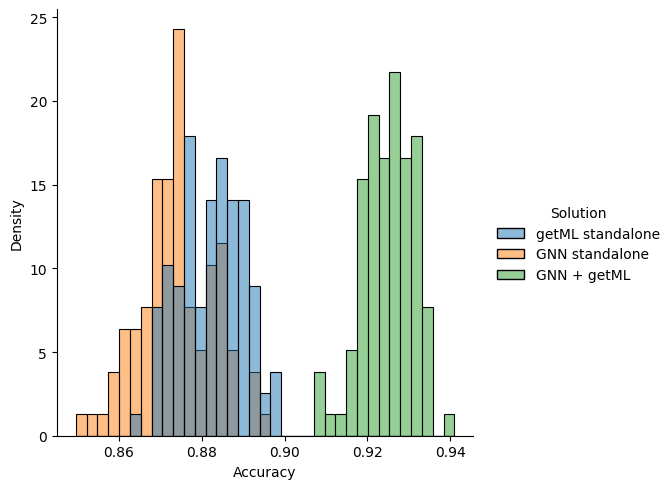

In [27]:
value_list = []
label_list = []

for label, accs in [
    ("getML standalone", getml_accs),
    ("GNN standalone", original_accs),
    ("GNN + getML", optimized_accs),
]:
    value_list = value_list + accs
    label_list = label_list + len(accs) * [label]
sns_df = pd.DataFrame({"Accuracy": value_list, "Solution": label_list})
sns.displot(sns_df, x="Accuracy", hue="Solution", stat="density", bins=35)

Though overlapping, we see that the getML standalone implementation performs slightly better than the GNN standalone solution. Much more eyecatching, however, is the massive boost in accuracy, when both approaches are combined and integrated.

When visualizing the learned embeddings of both GNN versions, the contrast between the two becomes also apparent. Let's quickly run a standalone GNN's model to output the node embeddings.

In [28]:
original_x = torch.tensor(
    index_aligned_df.word_vector.values.tolist(), dtype=torch.float32
)

y = torch.tensor(
    np.array(index_aligned_df["class_label_enc"].values), dtype=torch.long
)
edge_index = torch.tensor([cited_node, citing_node], dtype=torch.int64)

original_graph_object = Data(x=original_x, edge_index=edge_index, y=y)
original_graph_object.train_mask = torch.tensor(train_mask)
original_graph_object.test_mask = torch.tensor(test_mask)

In [30]:
nn_model = GCNConv(
    in_channels=original_graph_object.num_features,
    out_channels=len(original_graph_object.y.unique()),
)
original_gcn = GNNTrain(graph_object=original_graph_object, nn_model=nn_model)
original_gcn.run()
print("Maximum Test Accuracy: ", original_gcn.max_test_acc)

Epoch: 050, Train acc: 0.9420, Test acc: 0.8696
Epoch: 100, Train acc: 0.9567, Test acc: 0.8733
Epoch: 150, Train acc: 0.9636, Test acc: 0.8770
Epoch: 200, Train acc: 0.9641, Test acc: 0.8758
Epoch: 250, Train acc: 0.9657, Test acc: 0.8721
Epoch: 300, Train acc: 0.9668, Test acc: 0.8733
Epoch: 350, Train acc: 0.9662, Test acc: 0.8758
Epoch: 400, Train acc: 0.9673, Test acc: 0.8758
Epoch: 450, Train acc: 0.9668, Test acc: 0.8758
Epoch: 500, Train acc: 0.9673, Test acc: 0.8770
Epoch: 550, Train acc: 0.9673, Test acc: 0.8782
Epoch: 600, Train acc: 0.9678, Test acc: 0.8782
Epoch: 650, Train acc: 0.9678, Test acc: 0.8782
Epoch: 700, Train acc: 0.9678, Test acc: 0.8795
Epoch: 750, Train acc: 0.9678, Test acc: 0.8795
Epoch: 800, Train acc: 0.9673, Test acc: 0.8770
Epoch: 850, Train acc: 0.9673, Test acc: 0.8782
Epoch: 900, Train acc: 0.9673, Test acc: 0.8770
Epoch: 950, Train acc: 0.9673, Test acc: 0.8770
Epoch: 1000, Train acc: 0.9673, Test acc: 0.8770
Maximum Test Accuracy:  0.8794587945879

In [31]:
def visualize_embeddings(h1, h2, color):
    z1 = TSNE(n_components=2).fit_transform(h1.detach().cpu().numpy())
    z2 = TSNE(n_components=2).fit_transform(h2.detach().cpu().numpy())

    z1 = pd.DataFrame(z1)
    z1["label"] = color
    z2 = pd.DataFrame(z2)
    z2["label"] = color

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    sns.scatterplot(z1, x=0, y=1, hue="label", ax=ax1, palette="Set1")
    sns.scatterplot(z2, x=0, y=1, hue="label", ax=ax2, palette="Set1")

    ax1.set_title("GNN with getML features")
    ax2.set_title("GNN only")

    plt.show()

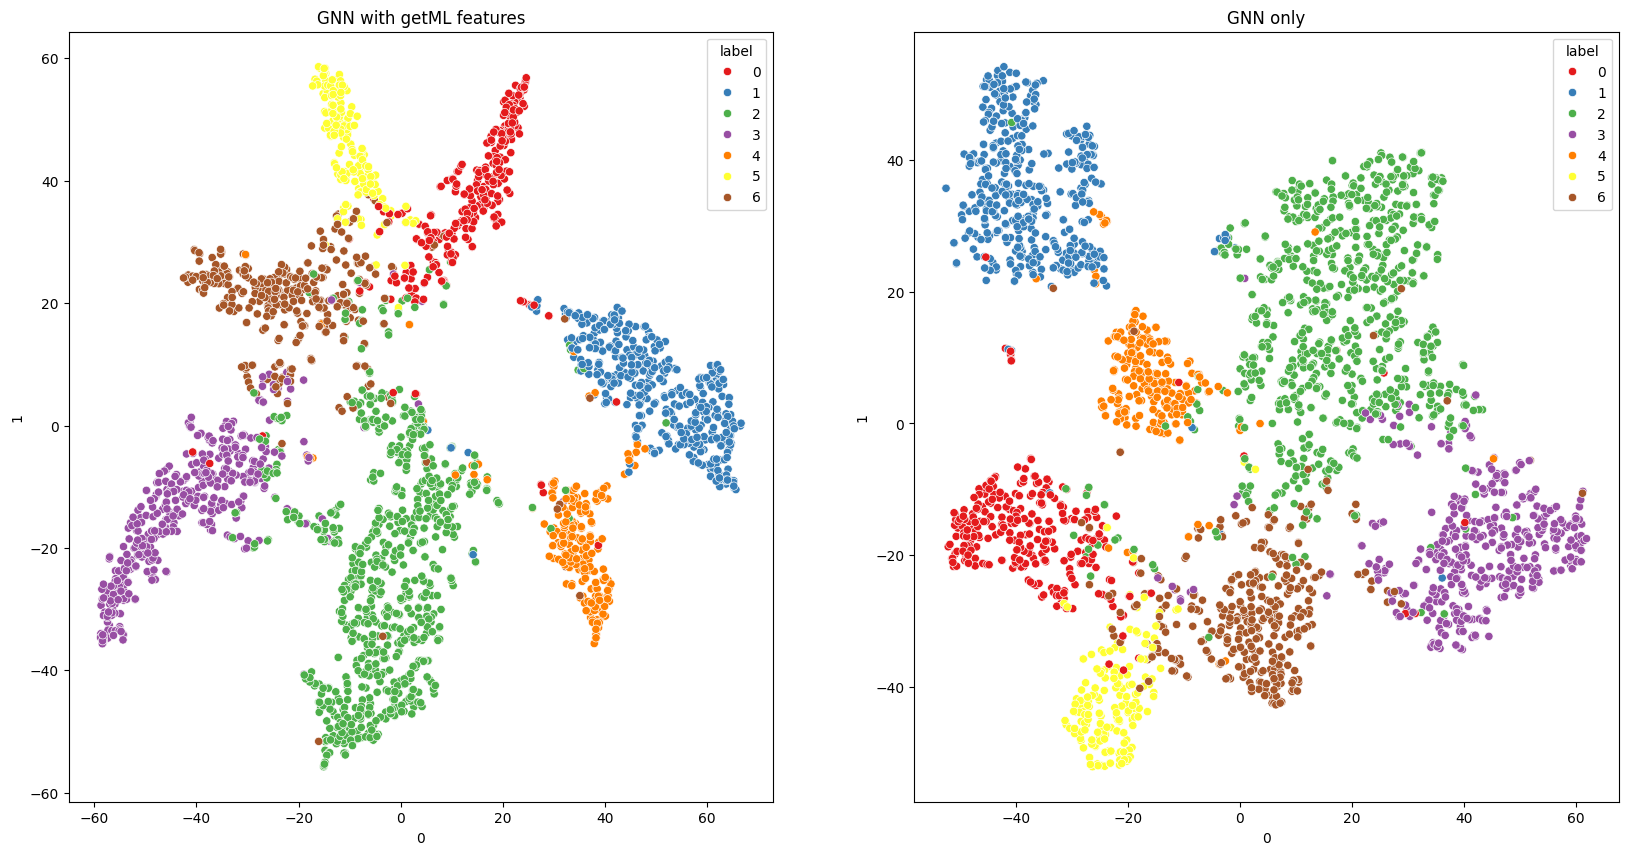

In [32]:
visualize_embeddings(
    optimized_gcn.best_model(
        optimized_graph_object.x, optimized_graph_object.edge_index
    ),
    original_gcn.best_model(original_graph_object.x, original_graph_object.edge_index),
    color=original_graph_object.y,
)

In the integrated solution, the learned embeddings are much better fine tuned to distinguish between labels. More coherent and well delineated label patches in the graphic representation above reflect that ability. That is the difference 5 percentage points of accuracy can make!

# Conclusion <a class="anchor"  id="Conclusion"></a>

In this notebook we have gone beyond the vanilla implementations of getML and GNN. Instead, we combined them and harnessed the best of both worlds. And the results, again, speak for themselves. A gain of more than 5% points in accuracy pushes that implementation well ahead of state of the art GNN development, and ranks us #1 at [Papers with Code](https://paperswithcode.com/sota/node-classification-on-cora).

In the next notebook we will explore the different neural net layers that pytorch provides and we will investigate how the choice of layers affects the performance when combined with getML feature engineering. So, stay tuned!